In [103]:
# 📦 Install required packages
!pip install catboost

In [104]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 📦 Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [105]:
# 📁 Load data
llama_sentiment = pd.read_csv("dogecoin_sentiment_llama4.csv")
finbert_vader_sentiment = pd.read_csv("dogecoin_sentiment_wo_emoji.csv")
price_df = pd.read_csv("DOGE_price_data.csv")

In [106]:
# === Timestamp and hour rounding ===
for df in [llama_sentiment, finbert_vader_sentiment]:
    df['created_utc'] = pd.to_datetime(df['created_utc'])
    df['hour'] = df['created_utc'].dt.floor('h') + pd.Timedelta(hours=1)  # SHIFT FORWARD to ensure no future leak

price_df['datetime'] = pd.to_datetime(price_df['datetime'])
price_df['hour'] = price_df['datetime'].dt.floor('h')

# === Merge sentiment ===
combined_sentiment = pd.merge(
    finbert_vader_sentiment,
    llama_sentiment[['created_utc', 'llm_sentiment_score']],
    on='created_utc',
    how='inner'
)
combined_sentiment['comment_count'] = combined_sentiment['comments'].apply(
    lambda x: len(eval(x)) if pd.notna(x) and x.startswith('[') else 0
)
combined_sentiment['engagement'] = combined_sentiment['score'] + combined_sentiment['comment_count'] + 1

# === Aggregate to hourly ===
agg_features = combined_sentiment.groupby('hour').agg({
    'vader_sentiment': lambda x: np.average(x, weights=combined_sentiment.loc[x.index, 'engagement']),
    'finbert_sliding_sentiment': lambda x: np.average(
        x.map({'positive': 1, 'neutral': 0, 'negative': -1}),
        weights=combined_sentiment.loc[x.index, 'engagement']
    ),
    'llm_sentiment_score': lambda x: np.average(x, weights=combined_sentiment.loc[x.index, 'engagement']),
    'avg_vader_comments': 'mean',
    'avg_finbert_comments': lambda x: np.average(
        x.map({'positive': 1, 'neutral': 0, 'negative': -1}),
        weights=combined_sentiment.loc[x.index, 'engagement']
    ),
    'engagement': 'sum',
    'score': 'sum',
    'comment_count': 'sum'
}).reset_index()

agg_features.rename(columns={
    'vader_sentiment': 'weighted_vader',
    'finbert_sliding_sentiment': 'weighted_finbert',
    'llm_sentiment_score': 'weighted_llm',
    'avg_vader_comments': 'comment_vader',
    'avg_finbert_comments': 'comment_finbert',
    'engagement': 'total_engagement',
    'score': 'total_upvotes',
    'comment_count': 'total_comments'
}, inplace=True)

# === Price features (ALL LAGGED) ===
price_df['volatility_lag1'] = (price_df['high'] - price_df['low']).shift(1)
price_df['close_lag1'] = price_df['close'].shift(1)
price_df['open_lag1'] = price_df['open'].shift(1)
price_df['price_change_lag1'] = price_df['close_lag1'] - price_df['open_lag1']
price_df['price_pct_change_lag1'] = price_df['price_change_lag1'] / price_df['open_lag1']
price_df['volume_lag1'] = price_df['volume'].shift(1)
price_df['volume_change_lag1'] = price_df['volume'].pct_change().shift(3)
price_df['rolling_close_lag'] = price_df['close'].shift(1).rolling(window=3).mean()
price_df['rolling_volume_lag'] = price_df['volume'].shift(1).rolling(window=2).mean()

# === Merge with sentiment ===
merged = pd.merge(price_df, agg_features, on='hour', how='inner')

# === Sort chronologically
merged = merged.sort_values('hour').reset_index(drop=True)

# === Target: Predict 24-hour-ahead price movement ===
merged['future_close'] = merged['close'].shift(-3)
merged['price_change_pct'] = (merged['future_close'] - merged['close']) / merged['close'] * 100
merged['price_movement_binary'] = (merged['price_change_pct'] > 0).astype(int)

# === Lagged Sentiment Features ===
merged['lag_weighted_llm'] = merged['weighted_llm'].shift(1)
merged['lag_weighted_finbert'] = merged['weighted_finbert'].shift(1)
merged['lag_weighted_vader'] = merged['weighted_vader'].shift(1)
merged['llm_sentiment_trend'] = merged['weighted_llm'] - merged['lag_weighted_llm']
merged['finbert_sentiment_trend'] = merged['weighted_finbert'] - merged['lag_weighted_finbert']
merged['vader_sentiment_trend'] = merged['weighted_vader'] - merged['lag_weighted_vader']


# === Rolling averages (lagged) ===
merged['rolling_llm_sentiment'] = merged['weighted_llm'].shift(1).rolling(window=2).mean()
merged['rolling_finbert_sentiment'] = merged['weighted_finbert'].shift(1).rolling(window=2).mean()
merged['rolling_vader_sentiment'] = merged['weighted_vader'].shift(1).rolling(window=2).mean()

# === Time-based Features & Lagged Momentum ===
merged['hour_of_day'] = merged['hour'].dt.hour
merged['day_of_week'] = merged['hour'].dt.dayofweek
merged['price_momentum_lag'] = merged['close'].pct_change(periods=2).shift(1) * 100
merged['prev_movement'] = merged['price_movement_binary'].shift(1)

merged['sentiment_volume_interaction'] = merged['weighted_llm'] * merged['volume_lag1']
merged['momentum_sentiment_interaction'] = merged['price_momentum_lag'] * merged['weighted_vader']

# 📊 Option 3: Volatility regime indicator
merged['avg_volatility'] = merged['volatility_lag1'].rolling(window=24).mean()

# === Clean up ===
merged.dropna(inplace=True)

# === Final features ===
features = [
    'weighted_vader', 'weighted_finbert', 'weighted_llm',
    'comment_vader', 'comment_finbert',
    'total_engagement', 'total_upvotes', 'total_comments',
    'volatility_lag1', 'price_change_lag1', 'price_pct_change_lag1',
    'volume_lag1', 'volume_change_lag1', 'rolling_close_lag', 'rolling_volume_lag',
    'llm_sentiment_trend', 'finbert_sentiment_trend', 'vader_sentiment_trend',
    'rolling_llm_sentiment', 'rolling_finbert_sentiment', 'rolling_vader_sentiment',
    'hour_of_day', 'day_of_week', 'price_momentum_lag', 'prev_movement',
    'sentiment_volume_interaction', 'momentum_sentiment_interaction',
]



In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

step_size = 48
start = 0
end = len(merged)

all_y_true = []
all_y_pred = []
all_y_prob = []
all_price_change_pct = []
all_test_indices = []

for i in range(start + 5 * step_size, end - step_size, step_size):
    train = merged.iloc[:i].copy()
    test = merged.iloc[i:i+step_size].copy()

    # Drop rows with missing values
    train.dropna(subset=features + ['price_movement_binary'], inplace=True)
    test.dropna(subset=features + ['price_movement_binary'], inplace=True)

    if train.empty or test.empty:
        continue

    X_train = train[features]
    y_train = train['price_movement_binary']
    X_test = test[features]
    y_test = test['price_movement_binary']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Handle any NaNs that might sneak in
    if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
        continue

    X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

    model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        eval_metric='Accuracy',
        verbose=False,
        random_state=42
    )
    model.fit(X_train_res, y_train_res)

    y_pred = (model.predict_proba(X_test_scaled)[:, 1] > 0.55).astype(int)

    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

    all_y_true.extend(y_test.tolist())
    all_y_pred.extend(y_pred.tolist())
    all_y_prob.extend(y_pred_prob.tolist())
    all_test_indices.extend(test.index.tolist())
    all_price_change_pct.extend(test['price_change_pct'].tolist())

# === Final evaluation ===
print("✅ Walk-Forward Classification Report:")
print(classification_report(all_y_true, all_y_pred))
print("📊 Confusion Matrix:")
print(confusion_matrix(all_y_true, all_y_pred))


✅ Walk-Forward Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       331
           1       0.68      0.66      0.67       341

    accuracy                           0.67       672
   macro avg       0.67      0.67      0.67       672
weighted avg       0.67      0.67      0.67       672

📊 Confusion Matrix:
[[223 108]
 [116 225]]


In [108]:
# === Visualization of confusion matrix ===
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# === ROC Curve (for binary classification) ===
def plot_auc_roc(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Feature Importance for CatBoost ===
def plot_feature_importance(model, features):
    feature_importances = model.get_feature_importance()
    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance from CatBoost')
    plt.gca().invert_yaxis()
    plt.show()


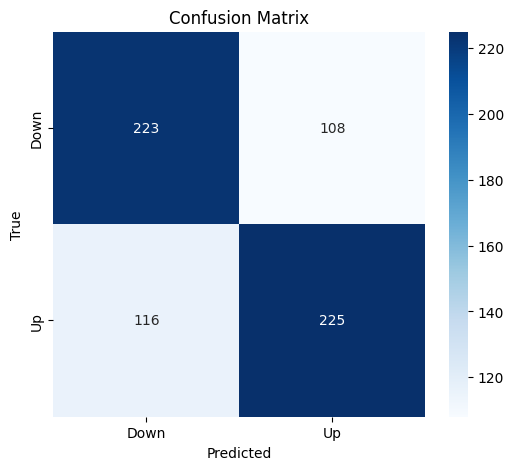

In [109]:
# === Confusion Matrix ===
cm = confusion_matrix(all_y_true, all_y_pred)
plot_confusion_matrix(cm, classes=['Down', 'Up'])

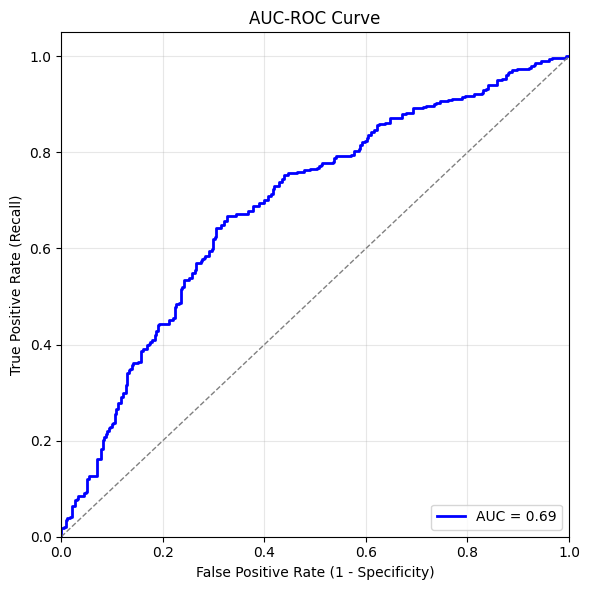

In [110]:
# === ROC Curve ===
plot_auc_roc(all_y_true, all_y_prob)

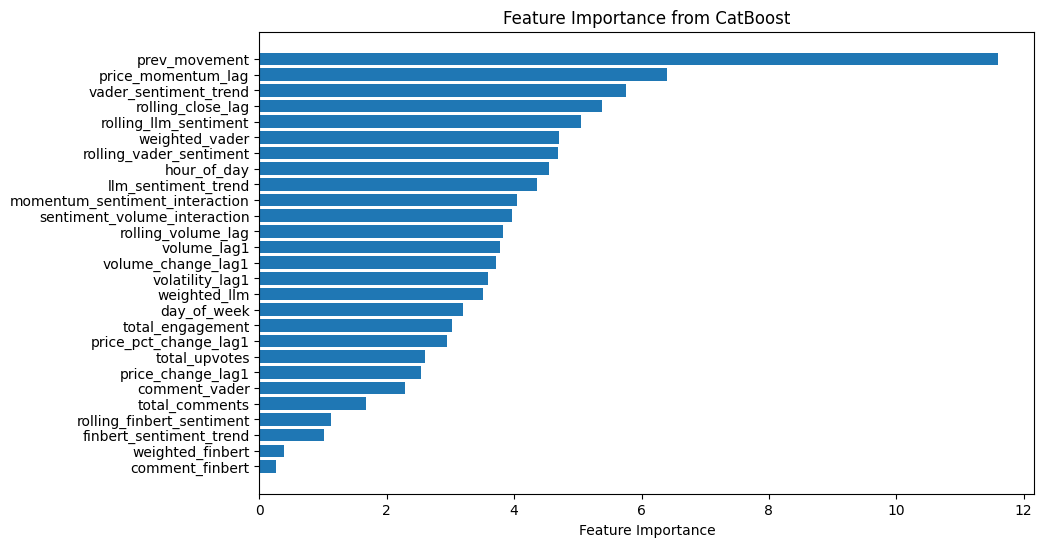

In [111]:
# === Feature Importance ===
plot_feature_importance(model, features)

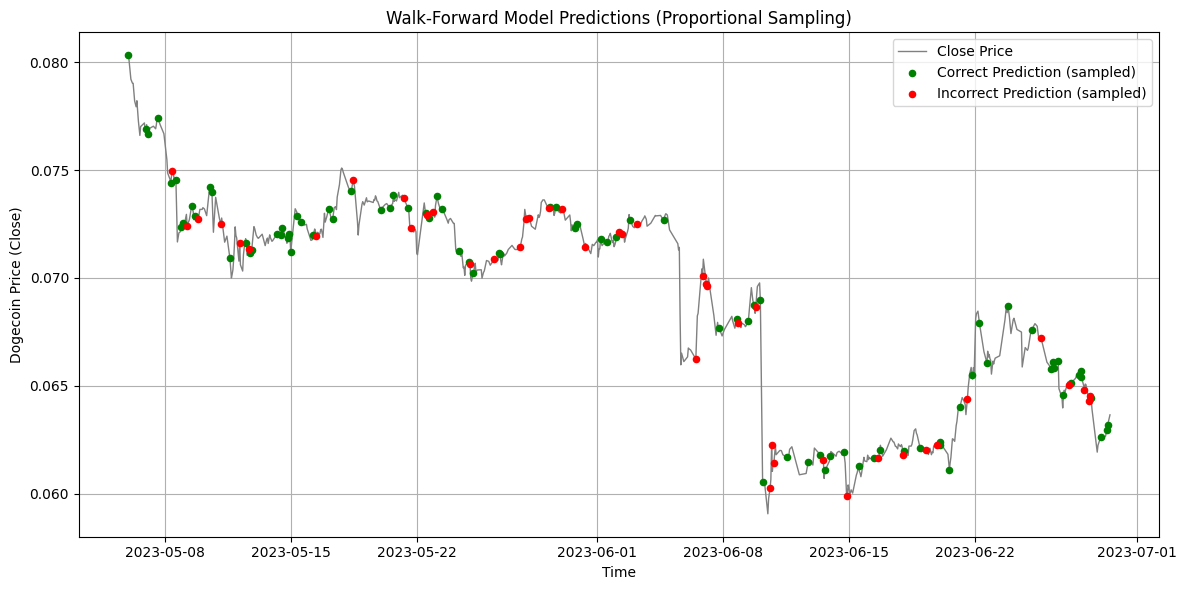

In [112]:
# === Create DataFrame from walk-forward results ===
results_df = pd.DataFrame({
    'index': all_test_indices,
    'actual': all_y_true,
    'predicted': all_y_pred
})

# === Add time and close price from merged DataFrame ===
merged_reset = merged.reset_index(drop=True)
results_df = results_df.merge(merged_reset[['hour', 'close']], left_on='index', right_index=True)

# === Split into correct and incorrect
correct = results_df[results_df['actual'] == results_df['predicted']]
incorrect = results_df[results_df['actual'] != results_df['predicted']]

# === Proportional sampling from each group (20% shown)
correct_sample = correct.sample(frac=0.2, random_state=42)
incorrect_sample = incorrect.sample(frac=0.2, random_state=42)

# === Plot
plt.figure(figsize=(12, 6))
plt.plot(results_df['hour'], results_df['close'], color='gray', label='Close Price', linewidth=1)

# Plot correct predictions first (underneath)
plt.scatter(correct_sample['hour'], correct_sample['close'], color='green',
            label='Correct Prediction (sampled)', s=20, zorder=4)

# Plot incorrect predictions on top
plt.scatter(incorrect_sample['hour'], incorrect_sample['close'], color='red',
            label='Incorrect Prediction (sampled)', s=20, zorder=5)

plt.xlabel('Time')
plt.ylabel('Dogecoin Price (Close)')
plt.title('Walk-Forward Model Predictions (Proportional Sampling)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


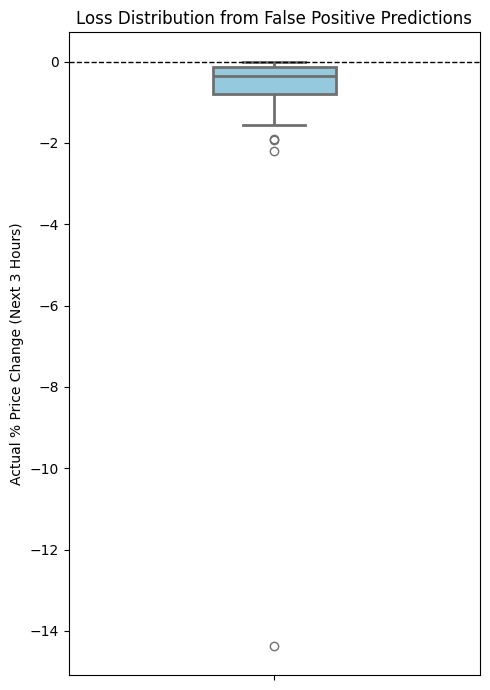

count    108.000000
mean      -0.647155
std        1.416822
min      -14.368566
25%       -0.791889
50%       -0.364320
75%       -0.134099
max        0.000000
Name: price_change_pct, dtype: float64
Empty DataFrame
Columns: [index, actual, predicted, price_change_pct]
Index: []


In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Create results dataframe from walk-forward loop directly ===
results_df = pd.DataFrame({
    'index': all_test_indices,
    'actual': all_y_true,
    'predicted': all_y_pred,
    'price_change_pct': all_price_change_pct
})

# === Filter only false positives (Predicted up, but price went down)
false_positives = results_df[(results_df['predicted'] == 1) & (results_df['actual'] == 0)]

# === Plot boxplot of actual price loss from false positives
plt.figure(figsize=(5, 7))
sns.boxplot(
    y=false_positives['price_change_pct'],
    color='skyblue',
    fliersize=6,
    linewidth=2,
    width=0.3
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel('Actual % Price Change (Next 3 Hours)')
plt.title('Loss Distribution from False Positive Predictions')
plt.tight_layout()
plt.show()

# === Sanity check
print(false_positives['price_change_pct'].describe())
print(false_positives[false_positives['price_change_pct'] > 0])  # should be empty


In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Target: 1-hour-ahead future close ===
merged['future_close'] = merged['close'].shift(-1)

# === Feature engineering ===
merged['close_pct_lag1'] = merged['close'].pct_change().shift(1)
merged['close_pct_lag2'] = merged['close'].pct_change().shift(2)
merged['rolling_sentiment_vol'] = merged['weighted_llm'].rolling(window=6).std().shift(1)
merged['rolling_price_vol'] = merged['close'].rolling(window=6).std().shift(1)

# === Update features list ===
features += ['close_pct_lag1', 'close_pct_lag2', 'rolling_sentiment_vol', 'rolling_price_vol']

# === Drop NaNs ===
merged.dropna(subset=features + ['close', 'future_close'], inplace=True)
merged['future_pct_change'] = (merged['future_close'] - merged['close']) / merged['close']

# === 80/20 time-based split ===
split_idx = int(0.8 * len(merged))
train = merged.iloc[:split_idx].copy()
test = merged.iloc[split_idx:].copy()

train.dropna(subset=features + ['future_pct_change'], inplace=True)
test.dropna(subset=features + ['future_pct_change'], inplace=True)

X_train = train[features]
y_train = train['future_pct_change']
X_test = test[features]
y_test = test['future_pct_change']
test_close = test['close']  # For rescaling prediction

# === Standardize ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Train model ===
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    eval_metric='RMSE',
    verbose=False,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# === Predict ===
y_pred_pct = model.predict(X_test_scaled)
y_pred_actual = test_close.values * (1 + y_pred_pct)
y_true_actual = test['future_close'].values

# === Evaluation ===
mae = mean_absolute_error(y_true_actual, y_pred_actual)
mape = mean_absolute_percentage_error(y_true_actual, y_pred_actual) * 100
rmse = np.sqrt(mean_squared_error(y_true_actual, y_pred_actual))
r2 = r2_score(y_true_actual, y_pred_actual)

print("✅ 80/20 Evaluation (1-Hour Ahead Forecast):")
print(f"MAE:   {mae:.6f}")
print(f"MAPE:  {mape:.2f}%")
print(f"RMSE:  {rmse:.6f}")
print(f"R²:    {r2:.4f}")

✅ 80/20 Evaluation (1-Hour Ahead Forecast):
MAE:   0.000299
MAPE:  0.46%
RMSE:  0.000438
R²:    0.9641


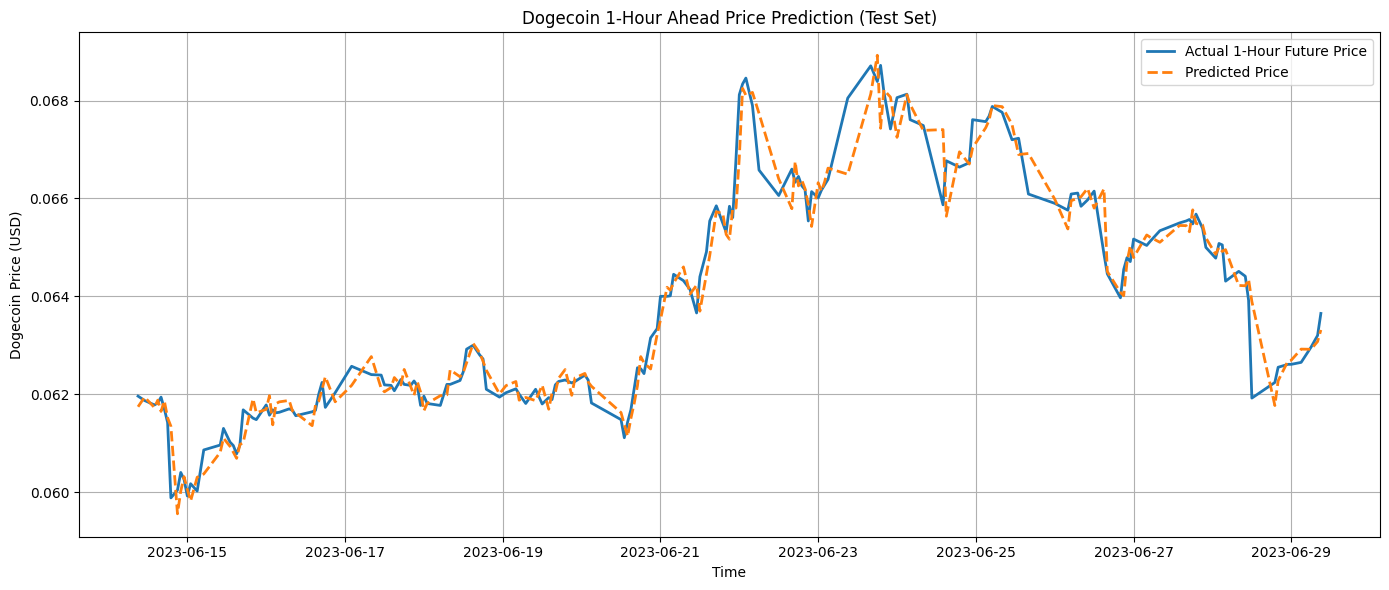

In [115]:
# === Prepare for plotting ===
results_df = test.copy().reset_index()
results_df['predicted'] = y_pred_actual
results_df['actual'] = y_true_actual
results_df = results_df[['index', 'hour', 'close', 'actual', 'predicted']]

# === Plot ===
results_df = results_df.sort_values('hour')
results_df['hour'] = pd.to_datetime(results_df['hour'])

plt.figure(figsize=(14, 6))
plt.plot(results_df['hour'], results_df['actual'], label='Actual 1-Hour Future Price', linewidth=2)
plt.plot(results_df['hour'], results_df['predicted'], label='Predicted Price', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Dogecoin Price (USD)')
plt.title('Dogecoin 1-Hour Ahead Price Prediction (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

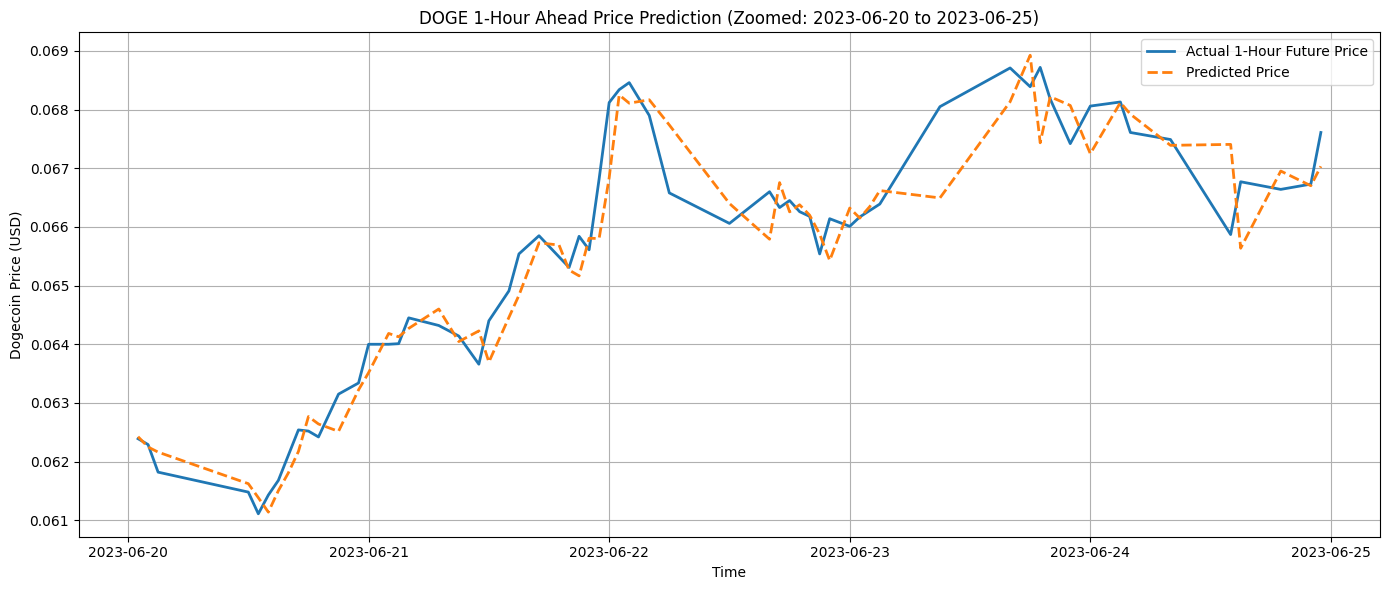

In [116]:
import matplotlib.pyplot as plt

# === Prepare for zoomed plot ===
results_df = test.copy().reset_index()
results_df['predicted'] = y_pred_actual
results_df['actual'] = y_true_actual
results_df = results_df[['index', 'hour', 'close', 'actual', 'predicted']].copy()

# ✅ Sort and parse 'hour'
results_df = results_df.sort_values('hour')
results_df['hour'] = pd.to_datetime(results_df['hour'])

# === Define zoom window (adjust these dates based on what's in your test set)
start_date = pd.to_datetime("2023-06-20")
end_date = start_date + pd.Timedelta(days=5)

# === Filter to the 5-day window
zoomed_df = results_df[(results_df['hour'] >= start_date) & (results_df['hour'] < end_date)]

# === Plot
plt.figure(figsize=(14, 6))
plt.plot(zoomed_df['hour'], zoomed_df['actual'], label='Actual 1-Hour Future Price', linewidth=2)
plt.plot(zoomed_df['hour'], zoomed_df['predicted'], label='Predicted Price', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Dogecoin Price (USD)')
plt.title(f'DOGE 1-Hour Ahead Price Prediction (Zoomed: {start_date.date()} to {end_date.date()})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [117]:
initial_cash = 10000
cash = initial_cash
position = 0
position_price = 0

min_trade_size = 2000
max_trade_size = 10000
min_threshold = 0.0009
max_threshold = 0.17

trades = []
trade_returns = []  # To store percent return per completed trade
open_trade = None   # Track open buy trade

for i in range(len(results_df)):
    pred_price = results_df.iloc[i]['predicted']
    actual_price = results_df.iloc[i]['actual']
    current_price = results_df.iloc[i]['close']
    timestamp = results_df.iloc[i]['hour']

    predicted_pct_increase = (pred_price - current_price) / current_price
    action = "Hold"
    profit = 0

    if predicted_pct_increase > min_threshold and position == 0:
        # Scale confidence into trade size
        confidence = predicted_pct_increase - min_threshold
        confidence = min(confidence, max_threshold - min_threshold)
        scale = confidence / (max_threshold - min_threshold)
        proposed_trade_size = min_trade_size + scale * (max_trade_size - min_trade_size)

        # Ensure we have enough cash to execute trade
        trade_size = min(proposed_trade_size, cash)

        if trade_size >= min_trade_size:  # Avoid micro-trades
            position = trade_size / current_price
            position_price = current_price
            cash -= trade_size
            action = f"Buy (${trade_size:.2f})"
            open_trade = {
                'buy_price': position_price,
                'timestamp': timestamp
            }

    elif predicted_pct_increase <= min_threshold and position > 0:
        # SELL
        sell_value = position * actual_price
        profit = sell_value - (position * position_price)
        # print(profit)
        cash += sell_value
        pct_return = ((actual_price - position_price) / position_price) * 100
        trade_returns.append(pct_return)
        position = 0
        position_price = 0
        action = "Sell"
        open_trade = None

    trades.append((timestamp, action, profit))

# === Final liquidation if still holding
if position > 0:
    final_price = results_df.iloc[-1]['actual']
    sell_value = position * final_price
    profit = sell_value - (position * position_price)
    cash += sell_value
    pct_return = ((final_price - position_price) / position_price) * 100
    trade_returns.append(pct_return)
    trades.append((results_df.iloc[-1]['hour'], 'Final Sell', profit))
    position = 0

# === Summary ===
net_gain = cash - initial_cash
num_buys = sum(1 for t in trades if "Buy" in t[1])
num_sells = sum(1 for t in trades if t[1] in ['Sell', 'Final Sell'])
avg_pct_return = sum(trade_returns) / len(trade_returns) if trade_returns else 0

print("Investor Simulation Results (Smart Budget-Aware Strategy):")
print(f"Initial Cash: ${initial_cash:.2f}")
print(f"Total Buys: {num_buys}")
print(f"Total Sells: {num_sells}")
print(f"Net Gain: ${net_gain:.2f}")
print(f"Average Return per Trade: {avg_pct_return:.2f}% across {len(trade_returns)} trades")
print(f"Return on Investment (ROI): {percent_gain:.2f}%")

# === Buy-and-Hold Comparison ===
start_price = results_df.iloc[0]['close']
end_price = results_df.iloc[-1]['actual']

baseline_pct_change = ((end_price - start_price) / start_price) * 100

print("\nBuy-and-Hold Baseline:")
print(f"Start Price: ${start_price:.4f}")
print(f"End Price:   ${end_price:.4f}")
print(f"Total Change Over Period: {baseline_pct_change:.2f}%")


Investor Simulation Results (Smart Budget-Aware Strategy):
Initial Cash: $10000.00
Total Buys: 30
Total Sells: 30
Net Gain: $568.60
Average Return per Trade: 0.92% across 30 trades
Return on Investment (ROI): 5.69%

Buy-and-Hold Baseline:
Start Price: $0.0619
End Price:   $0.0636
Total Change Over Period: 2.79%


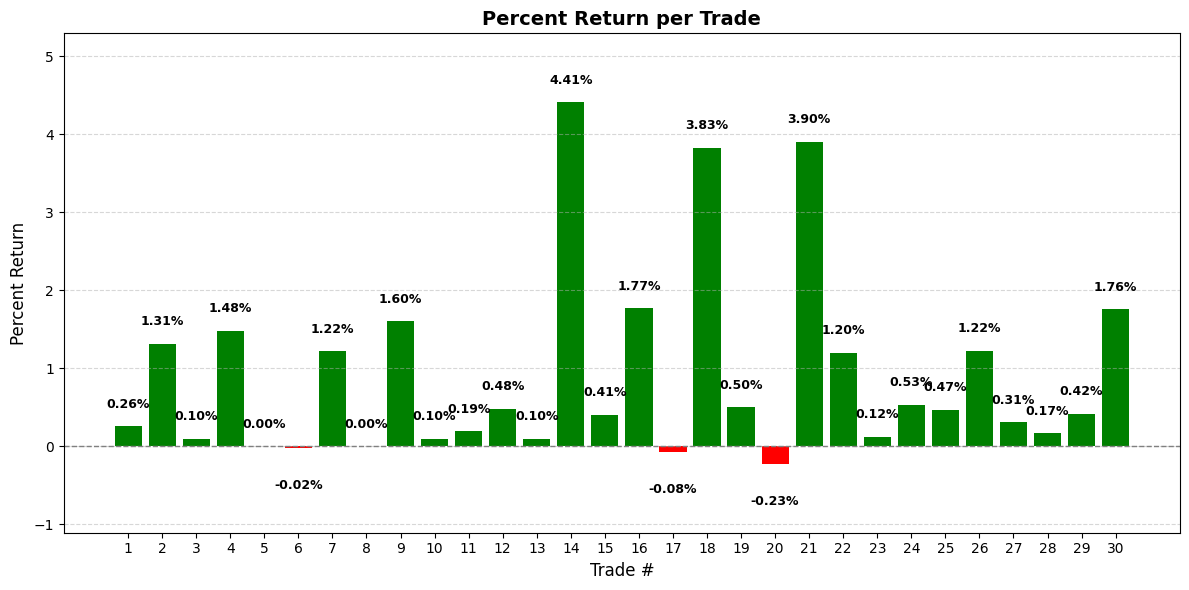

In [118]:
import matplotlib.pyplot as plt

if trade_returns:
    plt.figure(figsize=(12, 6))

    colors = ['green' if r >= 0 else 'red' for r in trade_returns]
    x_vals = range(1, len(trade_returns) + 1)
    bars = plt.bar(x_vals, trade_returns, color=colors)

    # Add labels above or below bars with padding
    for i, bar in enumerate(bars):
        height = bar.get_height()
        offset = 0.2 if height >= 0 else -0.4
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + offset,
                 f"{trade_returns[i]:.2f}%",
                 ha='center', va=va,
                 fontsize=9, fontweight='bold')

    # Auto adjust y-limits to leave space for labels
    max_height = max(trade_returns)
    min_height = min(trade_returns)
    padding = max(abs(max_height), abs(min_height)) * 0.2
    plt.ylim(min_height - padding, max_height + padding)

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Percent Return per Trade", fontsize=14, fontweight='bold')
    plt.xlabel("Trade #", fontsize=12)
    plt.ylabel("Percent Return", fontsize=12)
    plt.xticks(x_vals)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
else:
    print("No completed trades to plot.")
